#Multiple linear Regression for MNIST Images
## This notebook uses closed form solution

In [1]:
import torch
import torchvision

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

# Checking GPU availability
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


cuda:0


# MNIST dataset is part of torchvision
## Divide MNIST into training, validation and test sets
## Use DataLoader iterator for loading data in batches

In [2]:
from torch.utils.data import random_split


MNIST_training = torchvision.datasets.MNIST('/MNIST_dataset/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize((0.1307,), (0.3081,))]))

MNIST_test_set = torchvision.datasets.MNIST('/MNIST_dataset/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize((0.1307,), (0.3081,))]))

# create a training and a validation set
MNIST_training_set, MNIST_validation_set = random_split(MNIST_training, [55000, 5000])


train_loader = torch.utils.data.DataLoader(MNIST_training_set,batch_size=55000, shuffle=True)

validation_loader = torch.utils.data.DataLoader(MNIST_validation_set,batch_size=5000, shuffle=True)

test_loader = torch.utils.data.DataLoader(MNIST_test_set,batch_size=10000, shuffle=True)

0it [00:00, ?it/s]

9920512it [00:01, 5311660.04it/s]                             


Extracting /MNIST_dataset/MNIST/raw/train-images-idx3-ubyte.gz


  0%|          | 0/28881 [00:00<?, ?it/s]

32768it [00:00, 124876.84it/s]           
  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /MNIST_dataset/MNIST/raw/train-labels-idx1-ubyte.gz


1654784it [00:00, 2038261.35it/s]                            
0it [00:00, ?it/s]

Extracting /MNIST_dataset/MNIST/raw/t10k-images-idx3-ubyte.gz


8192it [00:00, 46841.18it/s]            


Extracting /MNIST_dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


## Check DataLoader

In [3]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
print(example_data.shape)
print(example_targets.shape)

torch.Size([10000, 1, 28, 28])
torch.Size([10000])


## Also, make sure to display some images

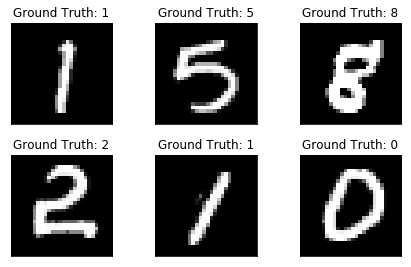

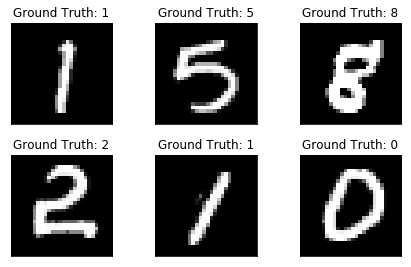

In [4]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

## Use closed form solution for $\theta$, $mean$ and $b$

In [0]:
# We need one hot encoding
# Following code appears at:  https://lirnli.wordpress.com/2017/09/03/one-hot-encoding-in-pytorch/
from torch import nn

class One_Hot(nn.Module):
    def __init__(self, depth):
        super(One_Hot,self).__init__()
        self.depth = depth
        self.ones = torch.sparse.torch.eye(depth)
    def forward(self, X_in):
        X_in = X_in.long()
        return self.ones.index_select(0,X_in.data)
    def __repr__(self):
        return self.__class__.__name__ + "({})".format(self.depth)

one_hot = One_Hot(10)

def Estimate_Parameters(train_X,train_y,lam):
  # flatten data
  train_X = train_X.view(train_X.size(0), -1)
  train_y = one_hot(train_y).float()

  # compute b
  b = torch.mean(train_y,dim=0,keepdim=True)
  # compute mean
  train_X_mean = torch.mean(train_X,dim=0,keepdim=True)
  # compute theta
  X = train_X - train_X_mean
  theta = torch.mm(torch.mm(torch.inverse(torch.matmul(X.t(),X)+lam*torch.eye(784)),X.t()),(train_y-b))

  return theta,train_X_mean,b


## Prediction on validation or test data with leanred model

In [0]:
def Model_Predict(X,theta,data_mean,b): # Notice prediction does not require *lam*
  X = X.view(X.size(0), -1)
  yp = torch.mm(X - data_mean, theta) + b
  return yp

## Accuracy computation

In [0]:
def Compute_Accuracy(yp,y):
  pred = yp.data.max(1, keepdim=True)[1]
  accuracy = (100. * pred.eq(y.data.view_as(pred)).sum()) / y.shape[0]
  return accuracy

## Estimating parameters of the model on training data

In [0]:
def Model_Train(lam):
  train_examples = enumerate(train_loader)
  batch_idx, (train_X, train_y) = next(train_examples)
  theta,data_mean,b = Estimate_Parameters(train_X,train_y,lam)
  return theta,data_mean,b

## Apply model on validation or test and evaluate accuracy

In [0]:
def Model_Evaluate(data_loader,theta,data_mean,b):
  # load  data
  examples = enumerate(data_loader)
  batch_idx, (X, y) = next(examples)

  # compute prediction
  yp = Model_Predict(X,theta,data_mean,b)

  # compute accuracy
  accuracy = Compute_Accuracy(yp,y)
  return accuracy

In [21]:
# Apply linear model on the validation and test sets
lam=0.1
theta,data_mean,b = Model_Train(lam)

validation_accuracy = Model_Evaluate(validation_loader,theta,data_mean,b)
print("Validation set accuracy:", validation_accuracy.item())

test_accuracy = Model_Evaluate(test_loader,theta,data_mean,b)
print("Test set accuracy:", test_accuracy.item())


torch.Size([1, 10])
Validation set accuracy: 84
Test set accuracy: 85


## Using validation set estimate best hyperparameter value

In [23]:
import numpy as np

best_accuracy = 0.0
best_lam = 0.0
for i in torch.range(-1,6,1):
  lam = np.power(10,i)
  theta, data_mean,b = Model_Train(lam)
  validation_accuracy = Model_Evaluate(validation_loader,theta, data_mean,b)
  print("Validation set accuracy:", validation_accuracy.item())
  if validation_accuracy>best_accuracy:
    best_lam = lam
    best_accuracy = validation_accuracy

# best hyperparameter
print(best_lam.item())
# estimate model with best hyperparameter value
best_theta, best_data_mean,best_b = Model_Train(best_lam)

# apply best model on test set
test_accuracy = Model_Evaluate(test_loader,best_theta, best_data_mean,best_b)
print("Test set accuracy:", test_accuracy.item())

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: torch.range is deprecated in favor of torch.arange and will be removed in 0.5. Note that arange generates values in [start; end), not [start; end].
  """


Validation set accuracy: 84
Validation set accuracy: 84
Validation set accuracy: 84
Validation set accuracy: 84
Validation set accuracy: 84
Validation set accuracy: 84
Validation set accuracy: 84
Validation set accuracy: 79
0.1
Test set accuracy: 85
